In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

Create fully connected netowrk

# number of out of  CNN layer
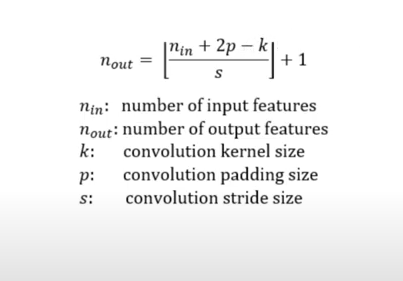

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, output_size):
        super(CNN, self).__init__() # call initialisation of the parent class
        # First 2D convolutional layer, taking in 1 input channel (image),
       # outputting 32 convolutional features, with a square kernel size of 3,3
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(784, output_size)


        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim =1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.reshape(x.shape[0], -1)
        #print("HELOO", x.shape) input shape will be printed linear layer after CNN
        x = self.softmax(self.fc1(x))

        return x


Set device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Hyperparameters

In [ ]:
in_channels = 1
num_classes = 10
lr = 0.01
batch_size = 64
num_epochs = 10

Load data

In [ ]:
train_dataset = datasets.MNIST(root='dataset/', train=True, transform = transforms.ToTensor(), download = True )
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

INitialise data

In [ ]:
model = CNN(in_channels=in_channels, output_size= num_classes).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


Loss and optimiser

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

Train netowrk

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device = device)
        targets = targets.to(device = device)

        score = model(data)
        loss = criterion(score, targets)

        # back prop
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()



Check accuracy

In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    """
    Check accuracy of our trained model given a loader and a model
    Parameters:
        loader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on
    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """

    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)


            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 87.94
Accuracy on test set: 88.17
